# Imports

In [1]:
import spotipy
import re

# math and dataframes
import pandas as pd
import numpy as np

# outliers, encoding, and normalisation
from sklearn.preprocessing import QuantileTransformer, minmax_scale, OneHotEncoder

# machine learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_parquet('df_10M.parquet')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_parquet('df_B100.parquet')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_parquet('df_B100_songs.parquet')

In [26]:
# confirm import worked (B100 songs are all in df_10M, no duplicates)
id_B100 = set(df_B100_songs[~df_B100_songs.id.isnull()].id)
len(id_B100), df_10M[df_10M.id.isin(id_B100)].shape[0]
# GOOD!

(22189, 22189)

# OUTLIERS

### Method 1:  IQR
(didn't work)

In [40]:
df_B100_range = df_B100_songs.describe().T[['min', 'max']]
df_outliers = df_10M.describe()['min':'max'].T

In [41]:
df_B100_range

,min,max
acousticness,0.000,0.995
danceability,0.000,0.988
duration_ms,30213.000,1561133.000
energy,0.007,0.999
instrumentalness,0.000,0.985
key,0.000,11.000
liveness,0.012,0.999
loudness,-30.346,2.291
mode,0.000,1.000
speechiness,0.000,0.951


In [42]:
df_outliers

,min,25%,50%,75%,max
acousticness,0.000,0.034,0.336,0.817,0.996
danceability,0.000,0.396,0.545,0.676,1.000
duration_ms,0.000,169600.000,216933.000,275080.000,19672058.000
energy,0.000,0.310,0.567,0.789,1.000
instrumentalness,0.000,0.000,0.002,0.645,1.000
key,0.000,2.000,5.000,8.000,11.000
liveness,0.000,0.096,0.129,0.262,1.000
loudness,-60.000,-13.675,-9.196,-6.398,7.234
mode,0.000,0.000,1.000,1.000,1.000
speechiness,0.000,0.036,0.047,0.082,0.974


In [43]:
df_outliers['IQR'] = df_outliers['75%'] - df_outliers['25%']
df_outliers['out_low'] = df_outliers['25%'] - 1.5 * df_outliers['IQR']
df_outliers['out_high'] = df_outliers['75%'] + 1.5 * df_outliers['IQR']
df_outliers

,min,25%,50%,75%,max,IQR,out_low,out_high
acousticness,0.000,0.034,0.336,0.817,0.996,0.783,-1.142,1.992
danceability,0.000,0.396,0.545,0.676,1.000,0.280,-0.024,1.096
duration_ms,0.000,169600.000,216933.000,275080.000,19672058.000,105480.000,11380.000,433300.000
energy,0.000,0.310,0.567,0.789,1.000,0.479,-0.408,1.507
instrumentalness,0.000,0.000,0.002,0.645,1.000,0.645,-0.967,1.612
key,0.000,2.000,5.000,8.000,11.000,6.000,-7.000,17.000
liveness,0.000,0.096,0.129,0.262,1.000,0.166,-0.152,0.510
loudness,-60.000,-13.675,-9.196,-6.398,7.234,7.277,-24.591,4.518
mode,0.000,0.000,1.000,1.000,1.000,1.000,-1.500,2.500
speechiness,0.000,0.036,0.047,0.082,0.974,0.046,-0.034,0.152


In [45]:
# this didn't exclude anything except liveliness > 0.51, speechiness > 0.152 and duration_ms
# let's check duration, to see if it's useful
df_outliers.loc['duration_ms', 'out_low'] / (60 * 1000), df_outliers.loc['duration_ms', 'out_high'] / (60 * 1000)

# 12 second songs, nope
# 7 minute songs, maybe

(0.18966666666666668, 7.221666666666667)

### Method 2:  Z-scores

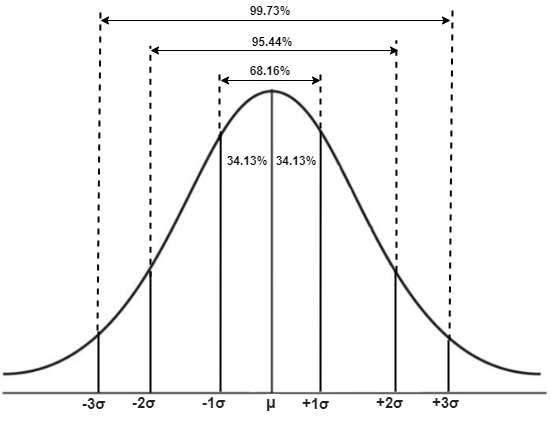

In [118]:
# helper function, check z scores
def check_z_score(z_exclude=3):
    z_scores = {1: 0.6816, 2: 0.9544, 3: 0.9973}
    z_exclude = z_exclude
    low_quartile = round((1 - z_scores[z_exclude]) / 2, 5)
    high_quartile = round(1 - (1 - z_scores[z_exclude]) / 2, 5)

    quartiles = [low_quartile, high_quartile]

    df_B100_range = df_B100_songs.describe().T
    df_10M_range = df_10M.describe(quartiles)['min':'max'].T

    output_df = pd.concat(
        [df_B100_range.rename({'min': 'B100_min', 'max': 'B100_max'}, axis=1), df_10M_range], 
        axis=1)
    
    output_df['low_error'] = output_df['B100_min'] - output_df[df_10M_range.columns[1]]
    output_df['high_error'] = output_df[df_10M_range.columns[3]] - output_df['B100_max']
    
    output_df.loc[['duration_ms', ]] = output_df.loc[['duration_ms', ]] / 60_000  # convert ms to minutes
    output_df = output_df.rename({'duration_ms': 'minutes'})
    
    return output_df[['B100_min', df_10M_range.columns[1], 'low_error', 'B100_max', df_10M_range.columns[3], 'high_error']]



In [119]:
# z-score > 3
z3 = check_z_score(3)

# z-score > 2
z2 = check_z_score(2)

In [142]:
z3

,B100_min,0.1%,low_error,B100_max,99.9%,high_error
acousticness,0.000,0.000,0.000,0.995,0.996,0.001
danceability,0.000,0.000,0.000,0.988,0.950,-0.038
minutes,0.504,0.134,0.370,26.019,25.133,-0.885
energy,0.007,0.001,0.006,0.999,0.999,0.000
instrumentalness,0.000,0.000,0.000,0.985,0.989,0.004
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.012,0.000,0.012,0.999,0.981,-0.018
loudness,-30.346,-40.120,9.774,2.291,-0.814,-3.105
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.000,0.000,0.951,0.960,0.009


In [143]:
z2

,B100_min,2.3%,low_error,B100_max,97.7%,high_error
acousticness,0.000,0.000,-0.000,0.995,0.993,-0.002
danceability,0.000,0.139,-0.139,0.988,0.859,-0.129
minutes,0.504,0.931,-0.428,26.019,8.890,-17.129
energy,0.007,0.027,-0.020,0.999,0.978,-0.021
instrumentalness,0.000,0.000,0.000,0.985,0.948,-0.037
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.012,0.048,-0.035,0.999,0.804,-0.195
loudness,-30.346,-27.796,-2.550,2.291,-3.047,-5.338
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.027,-0.027,0.951,0.506,-0.445


In [146]:
Z_errors = pd.concat([
    z3[[z3.columns[2], z3.columns[5]]].rename({z3.columns[2]: 'Z_error_low_3', z3.columns[5]: 'Z_error_high_3'}, axis=1), 
    z2[[z2.columns[2], z2.columns[5]]].rename({z2.columns[2]: 'Z_error_low_2', z2.columns[5]: 'Z_error_high_2'}, axis=1)], axis=1)
Z_errors

,Z_error_low_3,Z_error_high_3,Z_error_low_2,Z_error_high_2
acousticness,0.000,0.001,-0.000,-0.002
danceability,0.000,-0.038,-0.139,-0.129
minutes,0.370,-0.885,-0.428,-17.129
energy,0.006,0.000,-0.020,-0.021
instrumentalness,0.000,0.004,0.000,-0.037
key,0.000,0.000,0.000,0.000
liveness,0.012,-0.018,-0.035,-0.195
loudness,9.774,-3.105,-2.550,-5.338
mode,0.000,0.000,0.000,0.000
speechiness,0.000,0.009,-0.027,-0.445


In [156]:
df_sqerr = pd.DataFrame()
df_sqerr['Z3'] = Z_errors['Z_error_low_3'] * Z_errors['Z_error_low_3'] + Z_errors['Z_error_high_3'] * Z_errors['Z_error_high_3']
df_sqerr['Z2'] = Z_errors['Z_error_low_2'] * Z_errors['Z_error_low_2'] + Z_errors['Z_error_high_2'] * Z_errors['Z_error_high_2']
df_sqerr['Z3_is_best'] = df_sqerr['Z2'] > df_sqerr['Z3']
df_sqerr

# therefore Zscore of 3 is best for outlier removal

,Z3,Z2,Z3_is_best
acousticness,0.000,0.000,True
danceability,0.001,0.036,True
minutes,0.921,293.597,True
energy,0.000,0.001,True
instrumentalness,0.000,0.001,True
key,0.000,0.000,False
liveness,0.000,0.039,True
loudness,105.170,34.997,False
mode,0.000,0.000,False
speechiness,0.000,0.199,True


In [158]:
z3[[z3.columns[1], z3.columns[4]]]

,0.1%,99.9%
acousticness,0.000,0.996
danceability,0.000,0.950
minutes,0.134,25.133
energy,0.001,0.999
instrumentalness,0.000,0.989
key,0.000,11.000
liveness,0.000,0.981
loudness,-40.120,-0.814
mode,0.000,1.000
speechiness,0.000,0.960


In [159]:
df_B100_songs.describe().T[['min', 'max']]

,min,max
acousticness,0.000,0.995
danceability,0.000,0.988
duration_ms,30213.000,1561133.000
energy,0.007,0.999
instrumentalness,0.000,0.985
key,0.000,11.000
liveness,0.012,0.999
loudness,-30.346,2.291
mode,0.000,1.000
speechiness,0.000,0.951


In [167]:
# longest and shortest songs on B100
df_B100_songs.describe().T[['min', 'max']].rename({'duration_ms': 'minutes'}, axis=1).loc[['duration_ms']] / 60_000

,min,max
duration_ms,0.504,26.019


In [171]:
# yep, actually 26 minutes
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.max()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
17675,7ERSQrRptZVM7q3VOdM7OL,Tubular Bells,Mike Oldfield,album rock,1973-02-01,0.564,0.374,1561133,0.219,0.560,4,0.114,-19.104,0,0.034,103.535,4,0.058


In [170]:
# can't verify this using spotify's search
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.min()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
23319,13F8uvVT4s364jof2dn6XU,Fire,Subway,kirtan,2006-01-01,0.197,0.351,30213,0.532,0.110,6,0.443,-29.658,1,0.067,129.338,3,0.227


# QA part 2
### INVESTIGATE

##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [191]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

Enter token: BQCmBwexetSHMtplko1ryn61-FXK49ri29oigxMR5eH7U7mIhIt5WqHPi2LhCK0qwSUtNYLzbPvw6xgPPMfWJ_M2ngsP92P1V4wevF-NEZXvNRjGuHEHvGS3CEdfreQjSfXh1r4o2_TmrQuUDFafgFv71tVhEY6UKjn12Dk38vHn


In [192]:
def find_ids(track_title, artist_name):

    track_info = spotify.search(q='artist:' + artist_name + ' track:' + track_title, type='track')
    
    if track_info['tracks']['items'] == []:  # if track doesn't exist on Spotify
        return 'MISSING'
    else:
        track_ids = []
        number_of_results = len(track_info['tracks']['items'])
        
        # check if there is a better match
        for i in range(number_of_results):
            track_ids.append(track_info['tracks']['items'][i]['id'])
        
        # if we made it through the loop without returning, note 'MISSING' and return the 0th id
        return track_ids

In [193]:
fire_ids = find_ids('fire', 'subway')
fire_ids

['5udQ1aPE4n7TlpgRDuc2Ig',
 '7jcIL9Mu45wek2E9lGJNQX',
 '7hdwYE7yy4a5JHAKHtBDuG',
 '2oEZTflTVC8iiuOy1YdFsp',
 '1h93p3flwKkarQX06RlpCF',
 '2rHq6myVugSMTisc1U3BMD',
 '0OpvcOprsarOdtJPQeiJPu',
 '13F8uvVT4s364jof2dn6XU',
 '7t0FYIQYgDDTBuBnmXM5wh',
 '6j6Dc4XPpESGpEQ9vmLNA6']

In [188]:
spotify.track(fire_ids[0])['artists'][0]['name'], spotify.track(fire_ids[0])['name']

('Subway Terror', 'Subway Terror, Vol. 4')

In [189]:
output = []
for track_id in fire_ids:
    track = spotify.track(track_id)
    output.append([track['artists'][0]['name'], track['name']])
    
output

[['Subway Terror', 'Subway Terror, Vol. 4'],
 ['Subway Sounds', '4 Train'],
 ['Subway', 'Fire in Your Eyes'],
 ['Subway Force', 'Rainbow Fire - Variazione III'],
 ['DJ Subway', 'Beat 4 (Everything Funky)'],
 ['Subway Rockers', 'Call Me - Minimal Chic 4 The Floor Mix'],
 ['Subwayghost', '42nd Street'],
 ['Subway Rockers', 'Call Me - Minimal Chic 4 The Floor Mix'],
 ['Subway Bhaktis', 'On the Platform 4'],
 ['The Robotic Subwaymen', 'computing 444']]

* this track doesn't seem to be on spotify, but they have lyrics
* the algorithm would have defaulted to populating data for the first result, if there was no exact match
https://open.spotify.com/track/7p2e6DPXynAHq4m3uM3pLO

In [195]:
id_from_shortest_song = '13F8uvVT4s364jof2dn6XU'
track = spotify.track(id_from_shortest_song)
[track['artists'][0]['name'], track['name']]

# not sure why this one made it to the top of the list...

['Subway Bhaktis', 'On the Platform 4']

In [196]:
### REDO METADATA IDS ###

# Spotify 1.2M+ Songs
# via:  https://www.kaggle.com/datasets/
url_1M_songs = r'D:\RYERSON\820\Datasets\Spotify 1.2M+ Songs\tracks_features.csv'

# create the dataframe with the large number of songs metadata
df_1M_songs = pd.read_csv(url_1M_songs)

# make a list of song ids from the 1M dataset
metadata_ids_csv = df_1M_songs.id.to_list()


# all ids from the SQLite database
metadata_ids_SQL = pd.read_csv('all_ids_sql.csv', header=None, names=['id'])
metadata_ids_SQL = metadata_ids_SQL.id.to_list()

# audio feature data not imported yet (very large)


# list of ids for all of our known metadata
all_metadata_ids = set(metadata_ids_csv + metadata_ids_SQL) # set() faster to search, and no duplicates
len(all_metadata_ids)

9592981

In [200]:
id_from_shortest_song in all_metadata_ids

True

In [201]:
df_1M_songs[df_1M_songs.id==id_from_shortest_song]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date


In [202]:
df_10M[df_10M.id==id_from_shortest_song]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
17419,13F8uvVT4s364jof2dn6XU,Fire,Subway,kirtan,2006-01-01,0.197,0.351,30213,0.532,0.110,6,0.443,-29.658,1,0.067,129.338,3,0.227


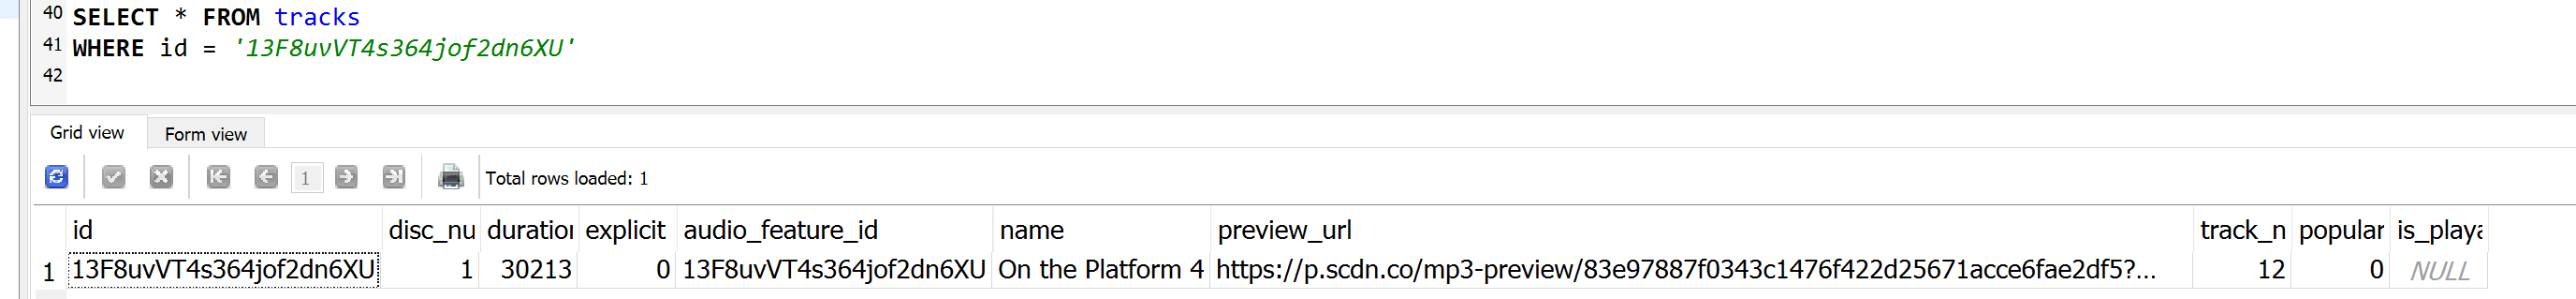

* this was a false positive
    * the song list from the spotify api search returned a match that was in the other dataset, but wasn't the actual song
    * should I redo phase 1 with a check for only exact matches for name?
    * alternative 2, confirm that song title matches exactly with spotify id song title
    * yuck
    * also, this would have overwritten songs from SQL with ids matching B100 songs
    

### check for mismatched names

In [246]:
matching_B100 = df_B100_songs[['id', 'song', 'artist']].copy()
matching_B100 = matching_B100.dropna().reset_index(drop=True)
track_id_list = matching_B100.id.tolist()

matching_B100['actual_song'] = ''
matching_B100['actual_artist'] = ''

matching_B100.head()

,id,song,artist,actual_song,actual_artist
0,7DZsH0df0GuULl0FGwXMfd,Misty,"""Groove"" Holmes",,
1,11Aldbvo6UCcVhBzv4oUdw,What Now My Love,"""Groove"" Holmes",,
2,4KRLWRl1bFjnXhY5MgZWrM,May The Bird Of Paradise Fly Up Your Nose,"""Little"" Jimmy Dickens",,
3,5r96TaQquRrlo3Ym3ZlSL2,Amish Paradise,"""Weird Al"" Yankovic",,
4,1gloYGAZI6eHp6MEPjLuL3,Canadian Idiot,"""Weird Al"" Yankovic",,


##### get a temporary authorization token from: https://developer.spotify.com/console/get-search-item

In [245]:
# input the temporary token
TEMP_TOKEN = input('Enter token: ')

# create a spotify object
spotify = spotipy.Spotify(auth=TEMP_TOKEN)

Enter token: BQDnPYIliqt_My7Ij8Z-qlCqeVlZR8db4xFZnQZEWmSN85PI4JRhcg5vG751W-q6ouT54lv4-8G8DowlEsdwjwy13PYyNUgRz5u68VHOQRSYOeQtNfA3F77a9nV_pfJuC2JTNg5FU9MvpgRyMSe02eGxRptaY4qBaEWkpRrZnFub


In [247]:
counter = 0
for i, row in matching_B100.iterrows():
    
    if i < 0:  # where we timed out last time
        continue
    
    track_id = matching_B100.iloc[i]['id']
    
    try:
        track = spotify.track(track_id)
        matching_B100.iloc[i]['actual_song'] = track['name']
        matching_B100.iloc[i]['actual_artist'] = track['artists'][0]['name']
    except:  # any error should yield missing
        matching_B100.iloc[i]['actual_song'] = 'MISSING'
        matching_B100.iloc[i]['actual_artist'] = 'MISSING'
    
    if counter % 100 == 0:
        print(counter, end=' ')
    if counter % 1000 == 0:
        print()
        matching_B100.to_parquet('matching_B100_TEMP.parquet')
        
    counter += 1

matching_B100.to_parquet('matching_B100_FINISHED.parquet')

0 
100 200 300 400 500 600 700 800 900 1000 
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 
2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 
3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 
4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 
5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 
6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 
7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 
8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 
9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 
10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 
11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 
12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 
13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 
14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 
15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 
16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 
17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 
18100 1

In [248]:
matching_B100.head()

,id,song,artist,actual_song,actual_artist
0,7DZsH0df0GuULl0FGwXMfd,Misty,"""Groove"" Holmes",Misty,"Richard ""Groove"" Holmes"
1,11Aldbvo6UCcVhBzv4oUdw,What Now My Love,"""Groove"" Holmes",What Now My Love,"Richard ""Groove"" Holmes"
2,4KRLWRl1bFjnXhY5MgZWrM,May The Bird Of Paradise Fly Up Your Nose,"""Little"" Jimmy Dickens",May the Bird of Paradise Fly up Your Nose,Little Jimmy Dickens
3,5r96TaQquRrlo3Ym3ZlSL2,Amish Paradise,"""Weird Al"" Yankovic","Amish Paradise (Parody of ""Gangsta's Paradise""...","""Weird Al"" Yankovic"
4,1gloYGAZI6eHp6MEPjLuL3,Canadian Idiot,"""Weird Al"" Yankovic","Canadian Idiot (Parody of ""American Idiot"" by ...","""Weird Al"" Yankovic"


### Reimport and check for false positives

In [3]:
matching_B100 = pd.read_parquet('matching_B100_FINISHED.parquet')

In [25]:
# helper function to clean artist and song data
def clean_text(text_input):
    text_input = text_input.strip().lower()
    text_input = re.sub(r'&', 'and', text_input)  # replaces & with 'and'
    text_input = re.sub(r'and.+', '', text_input)  # removes text after the 'and'
    text_input = re.compile(r'the').sub('', text_input)  # remove all 'the' (maybe just need the 1st word?)
    text_input = re.sub(r',.+', '', text_input)  # removes all misc artists, after comma 
    text_input = re.sub(r'(?:feat).+', '', text_input)  # removes all misc artists, after 'feat' 
    text_input = re.sub(r'\(.+', '', text_input)  # removes text after first bracket
    text_input = re.sub(r'\-.+', '', text_input)  # removes text after first dash
    text_input = re.compile(r'[^a-zA-Z 0-9]').sub('', text_input)  # remove punctuation
    text_input = re.sub(' +', ' ', text_input)  # remove multiple spaces
    return text_input.strip()

In [26]:
text_input = 'Gary Lewis & The Playboys'
clean_text(text_input)

'gary lewis'

In [21]:
matching_B100.head()

,id,song,artist,actual_song,actual_artist,song_match,artist_match
0,7DZsH0df0GuULl0FGwXMfd,Misty,"""Groove"" Holmes",Misty,"Richard ""Groove"" Holmes",True,False
1,11Aldbvo6UCcVhBzv4oUdw,What Now My Love,"""Groove"" Holmes",What Now My Love,"Richard ""Groove"" Holmes",True,False
2,4KRLWRl1bFjnXhY5MgZWrM,May The Bird Of Paradise Fly Up Your Nose,"""Little"" Jimmy Dickens",May the Bird of Paradise Fly up Your Nose,Little Jimmy Dickens,True,True
3,5r96TaQquRrlo3Ym3ZlSL2,Amish Paradise,"""Weird Al"" Yankovic","Amish Paradise (Parody of ""Gangsta's Paradise""...","""Weird Al"" Yankovic",True,True
4,1gloYGAZI6eHp6MEPjLuL3,Canadian Idiot,"""Weird Al"" Yankovic","Canadian Idiot (Parody of ""American Idiot"" by ...","""Weird Al"" Yankovic",True,True


In [27]:
matching_B100['song_match'] = matching_B100[['song']].applymap(clean_text).values == matching_B100[['actual_song']].applymap(clean_text).values
matching_B100['artist_match'] = matching_B100[['artist']].applymap(clean_text).values == matching_B100[['actual_artist']].applymap(clean_text).values

In [28]:
# number OK, number of songs with at least 1 error, number of song errors, number of artist errors, number of double errors

(
    matching_B100[(matching_B100['song_match'] & matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'])].shape[0],
    matching_B100[~(matching_B100['artist_match'])].shape[0],
    matching_B100[~(matching_B100['song_match'] | matching_B100['artist_match'])].shape[0],
)

#  OK, either, song, artist, both bad

(20473, 1716, 887, 949, 120)

In [29]:
# let's take a look
matching_B100[~(matching_B100['song_match'] & matching_B100['artist_match'])].sample(20)
# most look good

,id,song,artist,actual_song,actual_artist,song_match,artist_match
16088,2F44m6dP8mduVrc5dN9ccA,That Lovin' You Feelin' Again,Roy Orbison & Emmylou Harris,That Lovin' You Feelin' Again (with Roy Orbiso...,Emmylou Harris w/ Roy Orbison,True,False
15794,4o9Y7Gj0CnZoHqOrgvU9dJ,The Closer I Get To You,Roberta Flack With Donny Hathaway,The Closer I Get to You (with Donny Hathaway),Roberta Flack,True,False
213,7ycWLEP1GsNjVvcjawXz3z,L$D,A$AP Rocky,Praise The Lord (Da Shine) (feat. Skepta),A$AP Rocky,False,True
21961,1QlogZxaAT35c3HqjJt1JH,Situation,Yaz,Situation,Yazoo,True,False
8614,7AOKfZmM72axb2WtbOkn5C,close,J. Cole,Encore: Just A Closer Walk With Thee,Jason Coleman,False,False
14911,3PeiH20utGblIO1Bv82tmo,Up In A Puff Of Smoke,Polly Brown,Up In A Puff of Smoke,Polly Browne,True,False
4737,1EungMlGWzS9JjEIerBXHl,Me Myself And I,De La Soul,Me Myself and I (Soul Version),DJ De La Groove,True,False
19572,0C5XDWpf8fW2wLWVGpjm5W,Little Bit O' Soul,The Music Explosion,Little Bit O' Soul (Karaoke Version) (In The S...,The Karaoke Channel,True,False
4727,3sA7D3Z96m4QwTP6suyMPm,Summer Sand,Dawn,Summer Sand,Tony Orlando & Dawn,True,False
431,55tv2auMZGJsEHnCKSQBfn,"Oh Me, Oh My (Dreams In My Arms)",Al Green,Oh Me Oh My (Dreams in My Arms),Al Green,False,True


In [30]:
# what if both are wrong
matching_B100[~(matching_B100['song_match'] | matching_B100['artist_match'])].sample(20)
# most look wrong

,id,song,artist,actual_song,actual_artist,song_match,artist_match
15270,7oqslfvDarB1zRTUBlKehd,Out Of My Bones,Randy Travis,Karaoke - Out Of My Bones,Karaoke - Randy Travis,False,False
11608,7eO7rOwH5qVD3UWpO97qTI,The Voice,Lil Durk,Voice of the Heroes,Lil Baby,False,False
21590,4A1oVe9zn8PPRtziPujgxr,"Yeah, Yeah, Yeah!",Voices,Oh Yeah - Remastered Version,Voices Of East Harlem,False,False
5260,4dTIRwcRJO1Fmvd177n176,Goodbye Earl,Dixie Chicks,Karaoke - Goodbye Earl,Karaoke - Dixie Chicks,False,False
20475,2F5lnbTVW4doAUVBhD1PHh,Mau-Mau,The Wailers,Mr. Brown - Alex Nocera & Maurizio Montanari R...,Bob Marley & The Wailers,False,False
2005,3JeBMcbGWig0bYCGvnI5Ln,"Adeste Fideles (Oh, Come, All Ye Faithful)",Bing Crosby,"Adeste Fideles [Oh, Come All Ye Faithful]",Ella Fitzgerald & Bing Crosby,False,False
12588,3VgrSJEKBRT3xmwzpaxxEF,Heat Wave,Martha & The Vandellas,(Love Is Like A) Heat Wave,Martha Reeves & The Vandellas,False,False
15609,5W8n5Woo6DUSY40xRSM4my,That's All,Rick Nelson,That's All She Wrote,Ricky Nelson,False,False
11720,2WZ3s47ZLcVvPlTxSz8yJJ,Ta Da,Lil' Mo,Aku Tak Biasa - Live,Lilin Herlina Palapa,False,False
5285,5RLPoHTNovjxSAMQ5fevOy,Shooting Star,Dollar,Intro (Shooting Star),Yan Dollar,False,False


In [ ]:
wrong = [
    '1XduhVDrsLuMWk0fT0kbOx' # cover song of the song we wanted
]

In [33]:
# if we only exclude double false flags, this one gets included
matching_B100[matching_B100.id == '1XduhVDrsLuMWk0fT0kbOx']

,id,song,artist,actual_song,actual_artist,song_match,artist_match
18239,1XduhVDrsLuMWk0fT0kbOx,I Gotta Feeling,The Black Eyed Peas,I Gotta Feeling (Made Famous by Black Eyed Peas),The Rock Heroes,True,False


In [37]:
# maybe we need to redo id gathering for single false flags (currently 1716)

# first look at double true to see how good it is:
matching_B100[(matching_B100['song_match'] & matching_B100['artist_match'])].sample(20)
# all good (20 samples)
# all good (20 samples)
# all good (20 samples)
# 

,id,song,artist,actual_song,actual_artist,song_match,artist_match
5213,53QdLR7B8sP1O4AUvHEjdF,Here I Am,Dionne Warwick,Here I Am,Dionne Warwick,True,True
12091,0QUZYtRJ7dGe8fY9iuHd5E,True Blue Love,Lou Gramm,True Blue Love,Lou Gramm,True,True
14785,63CHa6rmamv9OsehkRD8oz,Against All Odds (Take A Look At Me Now),Phil Collins,Against All Odds (Take a Look at Me Now) - 201...,Phil Collins,True,True
10722,4NmE2ytXI8S2svTRSmEdpO,Small Talk,Katy Perry,Small Talk,Katy Perry,True,True
4313,5WFmMMxGnqMO5D5rerLAPn,Move Away,Culture Club,Move Away,Culture Club,True,True
20313,4gAsVttMY36zJUCa7FYoJN,Masterpiece,The Temptations,Masterpiece,The Temptations,True,True
7128,2QEnZJ8FwpBoyLKcFcgceT,Government Official,Future,Government Official,Future,True,True
3997,2EA4FAs7NDXbADRlPQWP2y,I Never Knew,Clyde McPhatter,I Never Knew,Clyde McPhatter,True,True
8950,4IM9fsiXjM877LYrIgPfYD,If You Gotta Make A Fool Of Somebody,James Ray,If You Gotta Make A Fool Of Somebody,James Ray,True,True
772,3ilYhdbWqY3mE1nlAhhOmh,I Engineer,Animotion,I Engineer,Animotion,True,True


# Need to Re-Gather ID data

* algorithm:
    * start with a list of ids to exclude
        * drop from both dataframes
            * B100 and 10M
    * check for match
        * look for exact matches using full text
        * look for exact matches using clean text
        * EXCLUDE
    * if match
        * look up audio features
        * look up genres
        
* after algo
    * re-merge dataframes and save results       
    
